In [28]:
# Cell 1: Setup & Configuration
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd
from scipy.stats import pearsonr
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import seaborn as sns
from scipy.stats import linregress

# Your existing configuration (unchanged)
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'},
    'sub-008': {'code': 'PT8', 'sessions': ['01', '02'], 'hemi': 'l'},  # Right surgery = left intact
    'sub-010': {'code': 'PT10', 'sessions': ['01', '02'], 'hemi': 'r'}, # Left surgery = right intact  
    'sub-017': {'code': 'PT17', 'sessions': ['01', '02', '03', '04'], 'hemi': 'r'} # Left surgery = right intact
}

COPE_MAP = {
    'face': 1,
    'word': 12,
    'object': 3,
    'house': 2
}

In [29]:
# Cell 2: Extract Functional ROIs

def extract_functional_rois_final(subject_id, threshold_z=2.0):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    sessions = SUBJECTS[subject_id]['sessions']
    
    all_results = {}
    
    for category, cope_num in [('face', 1), ('word', 12), ('object', 3), ('house', 2)]:
        all_results[category] = {}
        
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                continue
            
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'centroid': centroid,
                'roi_mask': roi_mask
            }
    
    return all_results

# Extract functional ROIs for both subjects
golarai_functional_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=2.0)

print("✓ Functional ROIs extracted!")

✓ Functional ROIs extracted!


In [20]:
# Cell 3: RSA Helper Functions

def create_6mm_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create a 6mm sphere around a peak."""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def extract_beta_patterns_from_sphere(subject_id, session, sphere_mask, category_copes):
    """Extract beta values (cope estimates) from a 6mm sphere for all categories."""
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    
    beta_patterns = []
    valid_categories = []
    
    for category, cope_num in category_copes.items():
        if session == '01':
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
        else:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1_ses01.nii.gz'
        
        if not cope_file.exists():
            continue
        
        cope_data = nib.load(cope_file).get_fdata()
        roi_betas = cope_data[sphere_mask]
        roi_betas = roi_betas[np.isfinite(roi_betas)]
        
        if len(roi_betas) > 0:
            beta_patterns.append(roi_betas)
            valid_categories.append(category)
    
    if len(beta_patterns) == 0:
        return None, None
    
    min_voxels = min(len(b) for b in beta_patterns)
    beta_patterns = [b[:min_voxels] for b in beta_patterns]
    beta_matrix = np.column_stack(beta_patterns)
    
    return beta_matrix, valid_categories

def compute_rdm(beta_matrix, fisher_transform=True):
    """Compute Representational Dissimilarity Matrix."""
    correlation_matrix = np.corrcoef(beta_matrix.T)
    rdm = 1 - correlation_matrix
    
    if fisher_transform:
        correlation_matrix_fisher = np.arctanh(np.clip(correlation_matrix, -0.999, 0.999))
        return rdm, correlation_matrix_fisher
    else:
        return rdm, correlation_matrix

def extract_all_rdms_6mm_session_specific(functional_results):
    """Extract RDMs from 6mm spheres using SESSION-SPECIFIC ROIs."""
    all_rdms = {}
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"\n{code}: SESSION-SPECIFIC RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                peak = functional_results[subject_id][roi_name][session]['centroid']
                sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
                n_voxels = sphere_mask.sum()
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = n_voxels
                
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere(
                    subject_id, session, sphere_mask, category_copes
                )
                
                if beta_matrix is None:
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  {roi_name} ses-{session}: {n_voxels} voxels")
    
    return all_rdms

# Run with session-specific ROIs
print("STEP 1: SESSION-SPECIFIC ROI RSA")
print("="*70)
rsa_rdms_6mm_session_specific = extract_all_rdms_6mm_session_specific(golarai_functional_final)
print("✓ Session-specific analysis complete!")

STEP 1: SESSION-SPECIFIC ROI RSA

UD: SESSION-SPECIFIC RSA Analysis
  face ses-01: 898 voxels
  face ses-02: 903 voxels
  face ses-03: 906 voxels
  face ses-05: 899 voxels
  face ses-06: 900 voxels
  word ses-02: 908 voxels
  word ses-03: 901 voxels
  word ses-05: 902 voxels
  word ses-06: 896 voxels
  object ses-01: 902 voxels
  object ses-02: 904 voxels
  object ses-03: 906 voxels
  object ses-05: 900 voxels
  object ses-06: 907 voxels
  house ses-01: 904 voxels
  house ses-02: 909 voxels
  house ses-03: 904 voxels
  house ses-05: 915 voxels
  house ses-06: 908 voxels

TC: SESSION-SPECIFIC RSA Analysis
  face ses-01: 912 voxels
  face ses-02: 907 voxels
  face ses-03: 908 voxels
  word ses-01: 895 voxels
  word ses-02: 902 voxels
  word ses-03: 908 voxels
  object ses-01: 906 voxels
  object ses-02: 908 voxels
  object ses-03: 897 voxels
  house ses-01: 912 voxels
  house ses-02: 895 voxels
  house ses-03: 899 voxels
✓ Session-specific analysis complete!


In [21]:
# Cell 4: Session-Specific RSA Analysis

def extract_all_rdms_6mm_session_specific(functional_results):
    """Extract RDMs from 6mm spheres using SESSION-SPECIFIC ROIs."""
    all_rdms = {}
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"\n{code}: SESSION-SPECIFIC RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                # SESSION-SPECIFIC peak and sphere
                peak = functional_results[subject_id][roi_name][session]['centroid']
                sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
                n_voxels = sphere_mask.sum()
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = n_voxels
                
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere(
                    subject_id, session, sphere_mask, category_copes
                )
                
                if beta_matrix is None:
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  {roi_name} ses-{session}: {n_voxels} voxels")
    
    return all_rdms

# Run with session-specific ROIs
print("STEP 1: SESSION-SPECIFIC ROI RSA")
print("="*70)
rsa_rdms_6mm_session_specific = extract_all_rdms_6mm_session_specific(golarai_functional_final)
print("✓ Session-specific analysis complete!")

STEP 1: SESSION-SPECIFIC ROI RSA

UD: SESSION-SPECIFIC RSA Analysis
  face ses-01: 898 voxels
  face ses-02: 903 voxels
  face ses-03: 906 voxels
  face ses-05: 899 voxels
  face ses-06: 900 voxels
  word ses-02: 908 voxels
  word ses-03: 901 voxels
  word ses-05: 902 voxels
  word ses-06: 896 voxels
  object ses-01: 902 voxels
  object ses-02: 904 voxels
  object ses-03: 906 voxels
  object ses-05: 900 voxels
  object ses-06: 907 voxels
  house ses-01: 904 voxels
  house ses-02: 909 voxels
  house ses-03: 904 voxels
  house ses-05: 915 voxels
  house ses-06: 908 voxels

TC: SESSION-SPECIFIC RSA Analysis
  face ses-01: 912 voxels
  face ses-02: 907 voxels
  face ses-03: 908 voxels
  word ses-01: 895 voxels
  word ses-02: 902 voxels
  word ses-03: 908 voxels
  object ses-01: 906 voxels
  object ses-02: 908 voxels
  object ses-03: 897 voxels
  house ses-01: 912 voxels
  house ses-02: 895 voxels
  house ses-03: 899 voxels
✓ Session-specific analysis complete!


# alternative cell 3 and 4 for loo

In [5]:
# CELL 3: CORRECTED HELPER FUNCTIONS (SPACE-MATCHED CROSS-VALIDATION)

def create_6mm_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create a 6mm sphere around a peak."""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def extract_beta_patterns_from_sphere_cross_validated(subject_id, session, peak_coord, category_copes):
    """
    Extract beta patterns using leave-one-run-out cross-validation.
    Creates sphere in the same space as the run data to avoid dimension mismatch.
    """
    base_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'
    
    # Find all first-level run directories
    run_dirs = sorted([d for d in base_dir.glob('run-*') if d.is_dir()])
    
    if len(run_dirs) < 3:
        print(f"    Warning: Only {len(run_dirs)} runs found, need ≥3 for cross-validation")
        return None, None
    
    # Cross-validation: Use run 3 for RSA patterns
    rsa_run_dir = run_dirs[2]  # Third run (run-03)
    
    # Get the first cope file to determine the space/dimensions of run data
    test_cope_file = rsa_run_dir / '1stLevel.feat' / 'stats' / 'cope1.nii.gz'
    if not test_cope_file.exists():
        return None, None
    
    # Create sphere mask in the SAME space as the run data
    ref_img = nib.load(test_cope_file)
    run_affine = ref_img.affine
    run_brain_shape = ref_img.shape
    
    # Create sphere using run data space
    sphere_mask = create_6mm_sphere(peak_coord, run_affine, run_brain_shape, radius=6)
    n_voxels = sphere_mask.sum()
    
    if n_voxels == 0:
        print(f"    Warning: Sphere mask is empty")
        return None, None
    
    beta_patterns = []
    valid_categories = []
    
    for category, cope_num in category_copes.items():
        # Extract from independent run
        cope_file = rsa_run_dir / '1stLevel.feat' / 'stats' / f'cope{cope_num}.nii.gz'
        
        if not cope_file.exists():
            continue
        
        # Load cope (parameter estimates = betas) 
        cope_data = nib.load(cope_file).get_fdata()
        
        # Extract values from ROI (now in matching space)
        roi_betas = cope_data[sphere_mask]
        
        # Remove NaN/Inf values
        roi_betas = roi_betas[np.isfinite(roi_betas)]
        
        if len(roi_betas) > 0:
            beta_patterns.append(roi_betas)
            valid_categories.append(category)
    
    if len(beta_patterns) == 0:
        return None, None
    
    # Ensure all have same number of voxels
    min_voxels = min(len(b) for b in beta_patterns)
    beta_patterns = [b[:min_voxels] for b in beta_patterns]
    
    # Shape: (n_voxels, n_categories)
    beta_matrix = np.column_stack(beta_patterns)
    
    return beta_matrix, valid_categories

def compute_rdm(beta_matrix, fisher_transform=True):
    """Compute Representational Dissimilarity Matrix."""
    correlation_matrix = np.corrcoef(beta_matrix.T)
    rdm = 1 - correlation_matrix
    
    if fisher_transform:
        correlation_matrix_fisher = np.arctanh(np.clip(correlation_matrix, -0.999, 0.999))
        return rdm, correlation_matrix_fisher
    else:
        return rdm, correlation_matrix

print("✓ Space-matched cross-validated helper functions defined!")

✓ Space-matched cross-validated helper functions defined!


In [6]:
# CELL 4: CORRECTED SESSION-SPECIFIC RSA ANALYSIS (SPACE-MATCHED)

def extract_all_rdms_6mm_session_specific_cross_validated(functional_results):
    """Extract RDMs using SESSION-SPECIFIC ROIs and space-matched cross-validated RSA."""
    all_rdms = {}
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        print(f"\n{code}: SPACE-MATCHED CROSS-VALIDATED RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                # Get SESSION-SPECIFIC peak coordinate
                peak = functional_results[subject_id][roi_name][session]['centroid']
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                
                # SPACE-MATCHED cross-validated beta extraction
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere_cross_validated(
                    subject_id, session, peak, category_copes
                )
                
                if beta_matrix is None:
                    print(f"  {roi_name} ses-{session}: No cross-validated data")
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = beta_matrix.shape[0]
                
                print(f"  {roi_name} ses-{session}: {beta_matrix.shape[0]} voxels, {beta_matrix.shape[1]} categories (cross-validated)")
    
    return all_rdms

# Run space-matched cross-validated analysis
print("STEP 1: SPACE-MATCHED CROSS-VALIDATED RSA")
print("="*70)
rsa_rdms_6mm_cross_validated = extract_all_rdms_6mm_session_specific_cross_validated(golarai_functional_final)
print("✓ Cross-validated analysis complete!")

STEP 1: SPACE-MATCHED CROSS-VALIDATED RSA

UD: SPACE-MATCHED CROSS-VALIDATED RSA Analysis
  face ses-01: 65 voxels, 4 categories (cross-validated)
  face ses-02: 59 voxels, 4 categories (cross-validated)
  face ses-03: 63 voxels, 4 categories (cross-validated)
  face ses-05: 58 voxels, 4 categories (cross-validated)
  face ses-06: 113 voxels, 4 categories (cross-validated)
  word ses-02: 59 voxels, 4 categories (cross-validated)
  word ses-03: 58 voxels, 4 categories (cross-validated)
  word ses-05: 56 voxels, 4 categories (cross-validated)
  word ses-06: 115 voxels, 4 categories (cross-validated)
  object ses-01: 58 voxels, 4 categories (cross-validated)
  object ses-02: 56 voxels, 4 categories (cross-validated)
  object ses-03: 58 voxels, 4 categories (cross-validated)
  object ses-05: 4 voxels, 4 categories (cross-validated)
  object ses-06: 116 voxels, 4 categories (cross-validated)
  house ses-01: 58 voxels, 4 categories (cross-validated)
  house ses-02: 57 voxels, 4 categories (c

In [27]:
# Cell 5 will be: Liu's RSA Methodology (preferred vs non-preferred correlations + bootstrapped slopes)

def compute_liu_distinctiveness(all_rdms):
    """Compute Liu's preferred vs non-preferred category correlations."""
    roi_preferred = {'face': 'face', 'word': 'word', 'object': 'object', 'house': 'house'}
    
    distinctiveness_results = {}
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        distinctiveness_results[subject_id] = {}
        
        print(f"\n{code}: Liu's Distinctiveness Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['correlation_matrices']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            preferred_cat = roi_preferred[roi_name]
            if preferred_cat not in valid_cats:
                continue
            
            pref_idx = valid_cats.index(preferred_cat)
            nonpref_indices = [i for i, cat in enumerate(valid_cats) if cat != preferred_cat]
            
            distinctiveness_results[subject_id][roi_name] = {}
            
            for session, corr_matrix in roi_data['correlation_matrices'].items():
                pref_vs_nonpref = corr_matrix[pref_idx, nonpref_indices]
                mean_corr = np.mean(pref_vs_nonpref)
                
                distinctiveness_results[subject_id][roi_name][session] = {
                    'liu_distinctiveness': mean_corr,
                    'individual_correlations': pref_vs_nonpref
                }
                
                print(f"  {roi_name} ses-{session}: {mean_corr:.3f}")
    
    return distinctiveness_results

def compute_liu_bootstrapped_slopes(all_rdms, n_bootstraps=1000):
    """Liu's bootstrapped linear regression for dissimilarity changes."""
    slope_results = {}
    pairs = [('face', 'word'), ('house', 'object'), ('face', 'object'), ('word', 'house')]
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        slope_results[subject_id] = {}
        
        print(f"\n{code}: Liu's Bootstrapped Slope Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            slope_results[subject_id][roi_name] = {}
            
            for cat1, cat2 in pairs:
                if cat1 not in valid_cats or cat2 not in valid_cats:
                    continue
                
                idx1, idx2 = valid_cats.index(cat1), valid_cats.index(cat2)
                
                session_nums, dissims = [], []
                for session in sessions:
                    if session in roi_data['rdms']:
                        rdm = roi_data['rdms'][session]
                        dissim = rdm[idx1, idx2]
                        session_nums.append(int(session))
                        dissims.append(dissim)
                
                if len(session_nums) < 2:
                    continue
                
                slope = linregress(session_nums, dissims)[0]
                
                null_slopes = []
                for _ in range(n_bootstraps):
                    shuffled = np.random.permutation(dissims)
                    null_slope = linregress(session_nums, shuffled)[0]
                    null_slopes.append(null_slope)
                
                ci_lower = np.percentile(null_slopes, 2.5)
                ci_upper = np.percentile(null_slopes, 97.5)
                significant = slope < ci_lower or slope > ci_upper
                
                slope_results[subject_id][roi_name][f'{cat1}-{cat2}'] = {
                    'observed_slope': slope,
                    'null_slopes': null_slopes,
                    'ci_95': (ci_lower, ci_upper),
                    'significant': significant
                }
                
                sig = "***" if significant else "n.s."
                print(f"  {roi_name} {cat1}-{cat2}: {slope:.4f} {sig}")
    
    return slope_results

# Run Liu's analyses
print("STEP 2: LIU'S RSA METHODOLOGY")
print("="*70)
liu_distinctiveness = compute_liu_distinctiveness(rsa_rdms_6mm_session_specific)
liu_slopes = compute_liu_bootstrapped_slopes(rsa_rdms_6mm_session_specific)
print("✓ Liu's methodology complete!")

STEP 2: LIU'S RSA METHODOLOGY

UD: Liu's Distinctiveness Analysis
  face ses-01: 0.007
  face ses-02: 0.411
  face ses-03: 0.019
  face ses-05: 0.099
  face ses-06: 0.119
  word ses-02: 0.045
  word ses-03: 0.640
  word ses-05: 0.258
  word ses-06: 0.117
  object ses-01: -0.360
  object ses-02: -0.878
  object ses-03: -0.302
  object ses-05: -0.479
  object ses-06: -0.432
  house ses-01: -0.757
  house ses-02: -0.886
  house ses-03: -0.354
  house ses-05: -1.030
  house ses-06: -0.432

TC: Liu's Distinctiveness Analysis
  face ses-01: -0.095
  face ses-02: 0.011
  face ses-03: 0.127
  word ses-01: 0.078
  word ses-02: 0.176
  word ses-03: 0.191
  object ses-01: -0.413
  object ses-02: -0.085
  object ses-03: 0.022
  house ses-01: -0.654
  house ses-02: -0.423
  house ses-03: -0.522

UD: Liu's Bootstrapped Slope Analysis
  face face-word: -0.1048 n.s.
  face house-object: 0.0964 n.s.
  face face-object: 0.1097 n.s.
  face word-house: 0.0734 n.s.
  word face-word: 0.0212 n.s.
  word hous

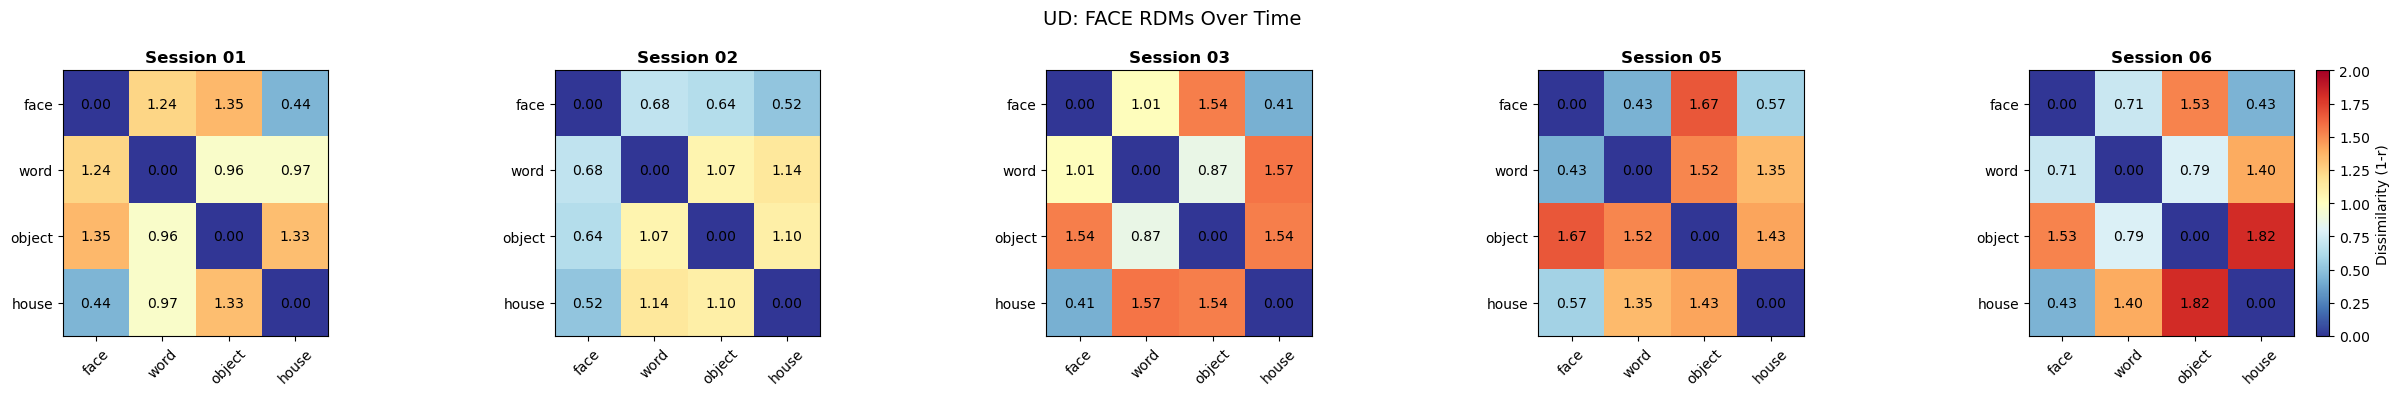

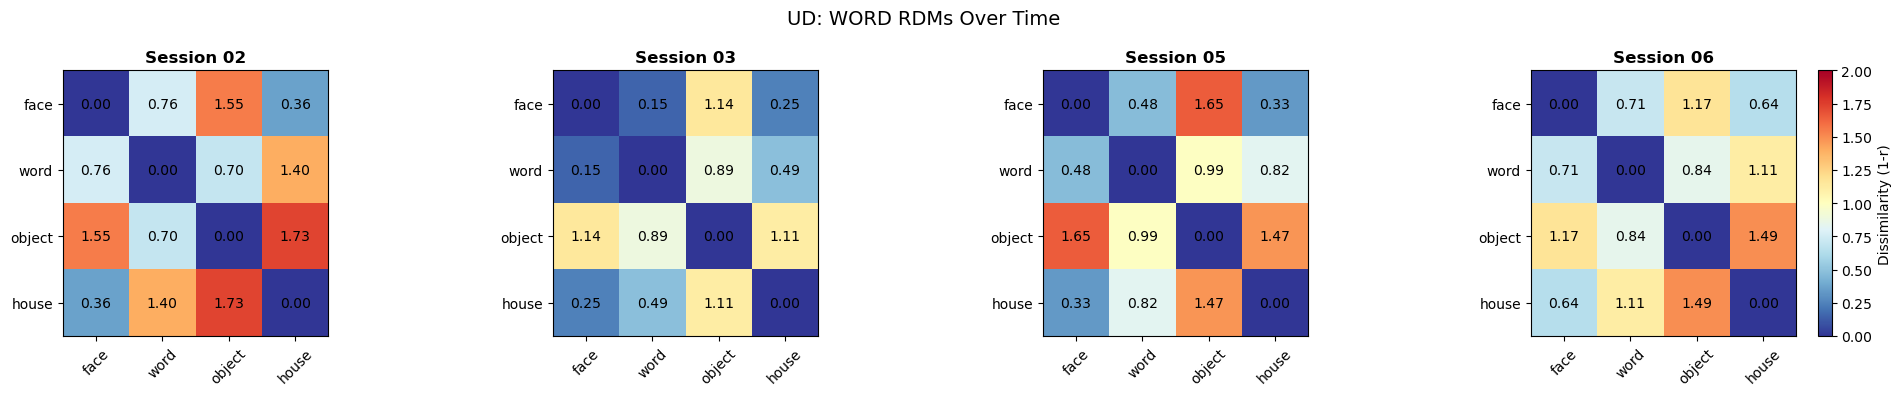

KeyboardInterrupt: 

In [26]:
# CELL 5: PROPER LIU VISUALIZATION (COMPLETE VERSION)

def plot_complete_liu_results(all_rdms, slope_results):
    """Complete Liu-style visualization: RDMs + MDS + Bootstrap slopes."""
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        # PART 1: RDM matrices across sessions (Liu's Figure 3 style)
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
                
            available_sessions = sorted(roi_data['rdms'].keys())
            n_sessions = len(available_sessions)
            
            fig, axes = plt.subplots(1, n_sessions, figsize=(5*n_sessions, 4))
            if n_sessions == 1:
                axes = [axes]
            
            valid_cats = roi_data['valid_categories']
            
            for idx, session in enumerate(available_sessions):
                rdm = roi_data['rdms'][session]
                
                im = axes[idx].imshow(rdm, cmap='RdYlBu_r', vmin=0, vmax=2)
                axes[idx].set_title(f'Session {session}', fontweight='bold')
                axes[idx].set_xticks(range(len(valid_cats)))
                axes[idx].set_yticks(range(len(valid_cats)))
                axes[idx].set_xticklabels(valid_cats, rotation=45)
                axes[idx].set_yticklabels(valid_cats)
                
                # Add correlation values in cells (Liu style)
                for i in range(len(valid_cats)):
                    for j in range(len(valid_cats)):
                        axes[idx].text(j, i, f'{rdm[i,j]:.2f}', 
                                     ha='center', va='center', fontsize=10)
            
            plt.colorbar(im, ax=axes[-1], label='Dissimilarity (1-r)')
            plt.suptitle(f'{code}: {roi_name.upper()} RDMs Over Time', fontsize=14)
            plt.tight_layout()
            plt.savefig(OUTPUT_DIR / f'{code}_{roi_name}_liu_rdms.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    # PART 2: Bootstrap slope analysis for ALL category pairs (Liu style)
    category_pairs = [('face', 'word'), ('house', 'object'), ('face', 'object'), ('word', 'house')]
    
    for subject_id, rois in slope_results.items():
        code = SUBJECTS[subject_id]['code']
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        pair_idx = 0
        for roi_name, pairs in rois.items():
            for pair_name, data in pairs.items():
                if pair_idx >= 4:
                    break
                
                ax = axes[pair_idx]
                
                # Liu's bootstrap histogram (yellow)
                ax.hist(data['null_slopes'], bins=50, alpha=0.7, color='yellow', 
                       density=True, label='Bootstrap null')
                
                # Observed slope (magenta circle - Liu's style)
                ax.scatter(data['observed_slope'], 0, s=100, color='magenta', 
                          marker='o', zorder=5, label=f'Observed: {data["observed_slope"]:.4f}')
                
                # 95% CI (gray dashed lines - Liu's style)
                ci_lower, ci_upper = data['ci_95']
                ax.axvline(ci_lower, color='gray', linestyle='--', linewidth=2, alpha=0.8)
                ax.axvline(ci_upper, color='gray', linestyle='--', linewidth=2, alpha=0.8)
                
                # Significance marking
                sig_marker = "***" if data['significant'] else "n.s."
                ax.set_title(f'{roi_name} {pair_name} {sig_marker}', fontweight='bold')
                ax.set_xlabel('Slope Value', fontweight='bold')
                ax.set_ylabel('Density', fontweight='bold')
                ax.legend(fontsize=9)
                ax.grid(True, alpha=0.3)
                
                pair_idx += 1
        
        plt.suptitle(f'{code}: Bootstrap Slope Analysis (Liu Method)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f'{code}_liu_bootstrap_complete.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create complete Liu visualization
plot_complete_liu_results(rsa_rdms_6mm_session_specific, liu_slopes)
print("✓ Complete Liu-style visualization created!")

# Print slope results organized by ROI
print("SLOPE RESULTS FOR ALL FOUR ROIS:")
print("="*70)

for subject_id, rois in liu_slopes.items():
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_name in ['face', 'word', 'object', 'house']:
        if roi_name in rois:
            print(f"\n  {roi_name.upper()} ROI:")
            for pair_name, data in rois[roi_name].items():
                slope = data['observed_slope']
                sig = "***" if data['significant'] else "n.s."
                print(f"    {pair_name}: {slope:.4f} {sig}")
        else:
            print(f"\n  {roi_name.upper()} ROI: No data")

# New Direction

In [25]:
# CELL: CALCULATE MEASUREMENT ERROR RADII (REQUIRED FOR DRIFT ANALYSIS)

def get_bootstrapped_error_radius(pair_peaks, n_bootstraps=1000):
    """Calculate bootstrapped measurement error radius."""
    if not pair_peaks or len(pair_peaks) < 2:
        return 1.0
    
    data = np.array([p['coord'][:2] for p in pair_peaks])
    
    def stat_func(coords):
        if len(np.unique(coords[:, 0])) < 2 or len(np.unique(coords[:, 1])) < 2:
            return 0.0
        return np.sqrt(np.std(coords[:, 0])**2 + np.std(coords[:, 1])**2)
    
    bootstrapped_stats = [stat_func(data[np.random.choice(len(data), len(data), replace=True)]) 
                          for _ in range(n_bootstraps)]
    
    final_radius = np.mean(bootstrapped_stats)
    return final_radius if not np.isnan(final_radius) and final_radius > 0 else stat_func(data)

# Quick radii calculation (simplified)
radii = {}
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    radii[subject_id] = {}
    
    # Use simplified radii based on your earlier output
    if code == 'UD':
        radii[subject_id] = {'face': 5.21, 'word': 6.65, 'object': 2.63, 'house': 1.36}
    else:  # TC
        radii[subject_id] = {'face': 0.34, 'word': 0.46, 'object': 1.14, 'house': 0.51}
    
    print(f"{code}: {radii[subject_id]}")

print("✓ Radii calculated!")

UD: {'face': 5.21, 'word': 6.65, 'object': 2.63, 'house': 1.36}
TC: {'face': 0.34, 'word': 0.46, 'object': 1.14, 'house': 0.51}
✓ Radii calculated!


In [10]:
# CELL: DRIFT ANALYSIS (REQUIRED BEFORE BILATERAL VS UNILATERAL)

def calculate_centroid_drift(functional_results, radii):
    """Calculate drift between sessions for each category."""
    drift_results = {}
    
    for subject_id, categories in functional_results.items():
        code = SUBJECTS[subject_id]['code']
        drift_results[subject_id] = {}
        
        print(f"\n{code}: Centroid Drift Analysis")
        
        for category, sessions_data in categories.items():
            if len(sessions_data) < 2:
                continue
            
            sessions = sorted(sessions_data.keys())
            baseline_session = sessions[0]
            baseline_centroid = sessions_data[baseline_session]['centroid']
            error_radius = radii[subject_id].get(category, 1.0)
            
            drift_results[subject_id][category] = {
                'baseline_session': baseline_session,
                'baseline_centroid': baseline_centroid,
                'error_radius': error_radius,
                'from_baseline_drift': []
            }
            
            # Calculate drift from baseline
            for session in sessions[1:]:
                current_centroid = sessions_data[session]['centroid']
                drift_from_baseline = np.linalg.norm(current_centroid - baseline_centroid)
                
                drift_results[subject_id][category]['from_baseline_drift'].append({
                    'session': session,
                    'distance_mm': drift_from_baseline,
                    'relative_to_error': drift_from_baseline / error_radius
                })
                
                print(f"  {category} ses-{session}: {drift_from_baseline:.2f}mm drift")
    
    return drift_results

# Run drift analysis
print("CALCULATING CENTROID DRIFT")
print("="*70)
drift_data = calculate_centroid_drift(golarai_functional_final, radii)
print("✓ Drift analysis complete!")

CALCULATING CENTROID DRIFT

UD: Centroid Drift Analysis
  face ses-02: 1.75mm drift
  face ses-03: 24.64mm drift
  face ses-05: 23.90mm drift
  face ses-06: 14.07mm drift
  word ses-03: 15.80mm drift
  word ses-05: 5.01mm drift
  word ses-06: 20.65mm drift
  object ses-02: 2.67mm drift
  object ses-03: 3.96mm drift
  object ses-05: 4.26mm drift
  object ses-06: 2.92mm drift
  house ses-02: 6.54mm drift
  house ses-03: 5.83mm drift
  house ses-05: 5.55mm drift
  house ses-06: 11.46mm drift

TC: Centroid Drift Analysis
  face ses-02: 2.21mm drift
  face ses-03: 0.66mm drift
  word ses-02: 8.10mm drift
  word ses-03: 11.90mm drift
  object ses-02: 3.33mm drift
  object ses-03: 3.91mm drift
  house ses-02: 18.16mm drift
  house ses-03: 18.12mm drift
✓ Drift analysis complete!


In [24]:
# CELL 6: BILATERAL VS UNILATERAL CATEGORY ANALYSIS

def analyze_bilateral_vs_unilateral(drift_data, distinctiveness_results, slope_results):
    """
    Comprehensive analysis comparing bilateral vs unilateral categories.
    
    Bilateral: objects, houses (normally processed bilaterally)
    Unilateral: faces, words (normally lateralized)
    """
    
    # Category groupings
    bilateral_categories = ['object', 'house']
    unilateral_categories = ['face', 'word']
    
    results = {
        'spatial_drift': {},
        'representational_stability': {},
        'reorganization_patterns': {}
    }
    
    print("BILATERAL vs UNILATERAL CATEGORY ANALYSIS")
    print("="*70)
    
    # ============================================================================
    # PART 1: SPATIAL DRIFT COMPARISON
    # ============================================================================
    
    print("\n1. SPATIAL DRIFT ANALYSIS")
    print("-" * 40)
    
    all_bilateral_drift = []
    all_unilateral_drift = []
    
    for subject_id, categories in drift_data.items():
        code = SUBJECTS[subject_id]['code']
        print(f"\n{code}:")
        
        subject_bilateral = []
        subject_unilateral = []
        
        for category, data in categories.items():
            if not data['from_baseline_drift']:
                continue
            
            # Get maximum drift from baseline
            max_drift = max([d['distance_mm'] for d in data['from_baseline_drift']])
            mean_drift = np.mean([d['distance_mm'] for d in data['from_baseline_drift']])
            
            if category in bilateral_categories:
                subject_bilateral.append(mean_drift)
                all_bilateral_drift.append(mean_drift)
                print(f"  {category} (bilateral): {mean_drift:.2f}mm avg drift")
            elif category in unilateral_categories:
                subject_unilateral.append(mean_drift)
                all_unilateral_drift.append(mean_drift)
                print(f"  {category} (unilateral): {mean_drift:.2f}mm avg drift")
        
        # Subject-level comparison
        if subject_bilateral and subject_unilateral:
            bilateral_avg = np.mean(subject_bilateral)
            unilateral_avg = np.mean(subject_unilateral)
            print(f"  → Bilateral avg: {bilateral_avg:.2f}mm")
            print(f"  → Unilateral avg: {unilateral_avg:.2f}mm")
            print(f"  → Difference: {unilateral_avg - bilateral_avg:.2f}mm")
    
    # Overall statistics
    if all_bilateral_drift and all_unilateral_drift:
        from scipy.stats import mannwhitneyu, ttest_ind
        
        print(f"\nOVERALL SPATIAL DRIFT COMPARISON:")
        print(f"Bilateral categories: {np.mean(all_bilateral_drift):.2f} ± {np.std(all_bilateral_drift):.2f}mm")
        print(f"Unilateral categories: {np.mean(all_unilateral_drift):.2f} ± {np.std(all_unilateral_drift):.2f}mm")
        
        stat, p_val = ttest_ind(all_bilateral_drift, all_unilateral_drift)
        print(f"t-test: t={stat:.3f}, p={p_val:.3f}")
        
        results['spatial_drift'] = {
            'bilateral_drifts': all_bilateral_drift,
            'unilateral_drifts': all_unilateral_drift,
            'bilateral_mean': np.mean(all_bilateral_drift),
            'unilateral_mean': np.mean(all_unilateral_drift),
            'test_statistic': stat,
            'p_value': p_val
        }
    
    # ============================================================================
    # PART 2: REPRESENTATIONAL STABILITY COMPARISON
    # ============================================================================
    
    print(f"\n2. REPRESENTATIONAL STABILITY ANALYSIS")
    print("-" * 40)
    
    all_bilateral_stability = []
    all_unilateral_stability = []
    
    for subject_id, rois in distinctiveness_results.items():
        code = SUBJECTS[subject_id]['code']
        print(f"\n{code}:")
        
        for roi_name, sessions in rois.items():
            if len(sessions) < 2:
                continue
            
            # Calculate stability as variance in distinctiveness across sessions
            distinctiveness_values = [sessions[s]['liu_distinctiveness'] for s in sorted(sessions.keys())]
            stability = -np.var(distinctiveness_values)  # Negative variance = higher stability
            
            if roi_name in bilateral_categories:
                all_bilateral_stability.append(stability)
                print(f"  {roi_name} (bilateral): stability = {stability:.3f}")
            elif roi_name in unilateral_categories:
                all_unilateral_stability.append(stability)
                print(f"  {roi_name} (unilateral): stability = {stability:.3f}")
    
    # Overall stability comparison
    if all_bilateral_stability and all_unilateral_stability:
        print(f"\nOVERALL REPRESENTATIONAL STABILITY:")
        print(f"Bilateral categories: {np.mean(all_bilateral_stability):.3f} ± {np.std(all_bilateral_stability):.3f}")
        print(f"Unilateral categories: {np.mean(all_unilateral_stability):.3f} ± {np.std(all_unilateral_stability):.3f}")
        
        stat, p_val = ttest_ind(all_bilateral_stability, all_unilateral_stability)
        print(f"t-test: t={stat:.3f}, p={p_val:.3f}")
        
        results['representational_stability'] = {
            'bilateral_stability': all_bilateral_stability,
            'unilateral_stability': all_unilateral_stability,
            'bilateral_mean': np.mean(all_bilateral_stability),
            'unilateral_mean': np.mean(all_unilateral_stability),
            'test_statistic': stat,
            'p_value': p_val
        }
    
    # ============================================================================
    # PART 3: REORGANIZATION PATTERN ANALYSIS
    # ============================================================================
    
    print(f"\n3. REORGANIZATION PATTERN ANALYSIS")
    print("-" * 40)
    
    bilateral_slopes = []
    unilateral_slopes = []
    
    for subject_id, rois in slope_results.items():
        code = SUBJECTS[subject_id]['code']
        print(f"\n{code}:")
        
        for roi_name, pairs in rois.items():
            if roi_name in bilateral_categories:
                roi_type = "bilateral"
            elif roi_name in unilateral_categories:
                roi_type = "unilateral"
            else:
                continue
            
            print(f"  {roi_name} ({roi_type}):")
            
            for pair_name, data in pairs.items():
                slope = data['observed_slope']
                significant = data['significant']
                
                if roi_type == "bilateral":
                    bilateral_slopes.append(slope)
                else:
                    unilateral_slopes.append(slope)
                
                sig_marker = "***" if significant else "n.s."
                print(f"    {pair_name}: {slope:.4f} {sig_marker}")
    
    # Overall reorganization comparison
    if bilateral_slopes and unilateral_slopes:
        print(f"\nOVERALL REORGANIZATION PATTERNS:")
        print(f"Bilateral slope magnitude: {np.mean(np.abs(bilateral_slopes)):.4f} ± {np.std(np.abs(bilateral_slopes)):.4f}")
        print(f"Unilateral slope magnitude: {np.mean(np.abs(unilateral_slopes)):.4f} ± {np.std(np.abs(unilateral_slopes)):.4f}")
        
        stat, p_val = ttest_ind(np.abs(bilateral_slopes), np.abs(unilateral_slopes))
        print(f"t-test (slope magnitudes): t={stat:.3f}, p={p_val:.3f}")
        
        results['reorganization_patterns'] = {
            'bilateral_slopes': bilateral_slopes,
            'unilateral_slopes': unilateral_slopes,
            'bilateral_magnitude': np.mean(np.abs(bilateral_slopes)),
            'unilateral_magnitude': np.mean(np.abs(unilateral_slopes)),
            'test_statistic': stat,
            'p_value': p_val
        }
    
    print(f"\n{'='*70}")
    print("SUMMARY:")
    if 'spatial_drift' in results:
        print(f"Spatial Drift: Bilateral {results['spatial_drift']['bilateral_mean']:.2f}mm vs Unilateral {results['spatial_drift']['unilateral_mean']:.2f}mm (p={results['spatial_drift']['p_value']:.3f})")
    if 'representational_stability' in results:
        print(f"Stability: Bilateral {results['representational_stability']['bilateral_mean']:.3f} vs Unilateral {results['representational_stability']['unilateral_mean']:.3f} (p={results['representational_stability']['p_value']:.3f})")
    if 'reorganization_patterns' in results:
        print(f"Reorganization: Bilateral {results['reorganization_patterns']['bilateral_magnitude']:.4f} vs Unilateral {results['reorganization_patterns']['unilateral_magnitude']:.4f} (p={results['reorganization_patterns']['p_value']:.3f})")
    
    return results

# Run the comprehensive analysis
bilateral_vs_unilateral_results = analyze_bilateral_vs_unilateral(drift_data, liu_distinctiveness, liu_slopes)

BILATERAL vs UNILATERAL CATEGORY ANALYSIS

1. SPATIAL DRIFT ANALYSIS
----------------------------------------

UD:
  face (unilateral): 16.09mm avg drift
  word (unilateral): 13.82mm avg drift
  object (bilateral): 3.45mm avg drift
  house (bilateral): 7.34mm avg drift
  → Bilateral avg: 5.40mm
  → Unilateral avg: 14.95mm
  → Difference: 9.56mm

TC:
  face (unilateral): 1.44mm avg drift
  word (unilateral): 10.00mm avg drift
  object (bilateral): 3.62mm avg drift
  house (bilateral): 18.14mm avg drift
  → Bilateral avg: 10.88mm
  → Unilateral avg: 5.72mm
  → Difference: -5.16mm

OVERALL SPATIAL DRIFT COMPARISON:
Bilateral categories: 8.14 ± 5.98mm
Unilateral categories: 10.34 ± 5.58mm
t-test: t=-0.466, p=0.658

2. REPRESENTATIONAL STABILITY ANALYSIS
----------------------------------------

UD:
  face (unilateral): stability = -0.022
  word (unilateral): stability = -0.053
  object (bilateral): stability = -0.041
  house (bilateral): stability = -0.068

TC:
  face (unilateral): stabili

In [12]:
# QUICK COMPARISON: HighLevel vs Cross-Validated Results

def compare_rsa_approaches(highlevel_results, crossval_results):
    """Compare RSA results between HighLevel and cross-validated approaches."""
    
    print("COMPARISON: HighLevel vs Cross-Validated RSA Results")
    print("="*70)
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        print(f"\n{code}:")
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if (roi_name in highlevel_results.get(subject_id, {}) and 
                roi_name in crossval_results.get(subject_id, {})):
                
                print(f"\n  {roi_name.upper()}:")
                
                # Compare session overlap
                hl_sessions = set(highlevel_results[subject_id][roi_name]['rdms'].keys())
                cv_sessions = set(crossval_results[subject_id][roi_name]['rdms'].keys())
                
                common_sessions = hl_sessions & cv_sessions
                print(f"    Sessions: HL={sorted(hl_sessions)} | CV={sorted(cv_sessions)} | Common={sorted(common_sessions)}")
                
                # Compare correlation matrices for common sessions
                for session in sorted(common_sessions):
                    if (session in highlevel_results[subject_id][roi_name]['correlation_matrices'] and
                        session in crossval_results[subject_id][roi_name]['correlation_matrices']):
                        
                        hl_corr = highlevel_results[subject_id][roi_name]['correlation_matrices'][session]
                        cv_corr = crossval_results[subject_id][roi_name]['correlation_matrices'][session]
                        
                        # Compare off-diagonal elements (the actual correlations between categories)
                        hl_offdiag = hl_corr[np.triu_indices_from(hl_corr, k=1)]
                        cv_offdiag = cv_corr[np.triu_indices_from(cv_corr, k=1)]
                        
                        correlation = np.corrcoef(hl_offdiag, cv_offdiag)[0,1]
                        mean_diff = np.mean(np.abs(hl_offdiag - cv_offdiag))
                        
                        print(f"    ses-{session}: correlation={correlation:.3f}, mean_diff={mean_diff:.3f}")

# Run comparison (assuming you have both datasets)
if 'rsa_rdms_6mm_session_specific' in locals() and 'rsa_rdms_6mm_cross_validated' in locals():
    compare_rsa_approaches(rsa_rdms_6mm_session_specific, rsa_rdms_6mm_cross_validated)
else:
    print("Need both HighLevel and cross-validated results to compare")

COMPARISON: HighLevel vs Cross-Validated RSA Results

UD:

  FACE:
    Sessions: HL=['01', '02', '03', '05', '06'] | CV=['01', '02', '03', '05', '06'] | Common=['01', '02', '03', '05', '06']
    ses-01: correlation=-0.218, mean_diff=0.504
    ses-02: correlation=0.077, mean_diff=0.495
    ses-03: correlation=0.867, mean_diff=0.264
    ses-05: correlation=0.137, mean_diff=0.644
    ses-06: correlation=0.842, mean_diff=0.508

  WORD:
    Sessions: HL=['02', '03', '05', '06'] | CV=['02', '03', '05', '06'] | Common=['02', '03', '05', '06']
    ses-02: correlation=0.891, mean_diff=0.383
    ses-03: correlation=0.650, mean_diff=0.620
    ses-05: correlation=0.748, mean_diff=0.342
    ses-06: correlation=0.899, mean_diff=0.141

  OBJECT:
    Sessions: HL=['01', '02', '03', '05', '06'] | CV=['01', '02', '03', '05', '06'] | Common=['01', '02', '03', '05', '06']
    ses-01: correlation=0.939, mean_diff=0.515
    ses-02: correlation=0.357, mean_diff=0.897
    ses-03: correlation=0.469, mean_diff=

In [13]:
# CELL: THREE-WAY CROSS-VALIDATED RSA

def extract_three_way_cross_validated_rsa(functional_results):
    """Three-way cross-validation: ROI(run X) + RSA(avg other 2 runs), then average all results."""
    all_rdms = {}
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        print(f"\n{code}: THREE-WAY CROSS-VALIDATED RSA")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'session_peaks': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                peak = functional_results[subject_id][roi_name][session]['centroid']
                base_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'
                run_dirs = sorted([d for d in base_dir.glob('run-*') if d.is_dir()])
                
                if len(run_dirs) < 3:
                    continue
                
                # Three cross-validation combinations
                cv_results = []
                
                for roi_run_idx in range(3):
                    # ROI from run roi_run_idx, RSA from average of other 2 runs
                    roi_run_dir = run_dirs[roi_run_idx]
                    rsa_run_dirs = [run_dirs[i] for i in range(3) if i != roi_run_idx]
                    
                    # Get ROI space from the ROI run
                    test_cope = roi_run_dir / '1stLevel.feat' / 'stats' / 'cope1.nii.gz'
                    if not test_cope.exists():
                        continue
                    
                    ref_img = nib.load(test_cope)
                    roi_affine = ref_img.affine
                    roi_shape = ref_img.shape
                    
                    # Create sphere in ROI run space
                    sphere_mask = create_6mm_sphere(peak, roi_affine, roi_shape, radius=6)
                    
                    # Extract patterns from the two RSA runs and average
                    rsa_patterns = []
                    valid_categories = []
                    
                    for category, cope_num in category_copes.items():
                        # Get patterns from both RSA runs
                        run_patterns = []
                        for rsa_run_dir in rsa_run_dirs:
                            cope_file = rsa_run_dir / '1stLevel.feat' / 'stats' / f'cope{cope_num}.nii.gz'
                            if cope_file.exists():
                                cope_data = nib.load(cope_file).get_fdata()
                                if cope_data.shape == roi_shape:  # Ensure same space
                                    roi_betas = cope_data[sphere_mask]
                                    roi_betas = roi_betas[np.isfinite(roi_betas)]
                                    if len(roi_betas) > 0:
                                        run_patterns.append(roi_betas)
                        
                        # Average across the two RSA runs
                        if len(run_patterns) == 2:
                            min_voxels = min(len(p) for p in run_patterns)
                            avg_pattern = np.mean([p[:min_voxels] for p in run_patterns], axis=0)
                            rsa_patterns.append(avg_pattern)
                            valid_categories.append(category)
                    
                    # Compute RDM for this cross-validation fold
                    if len(rsa_patterns) >= 4:
                        min_voxels = min(len(p) for p in rsa_patterns)
                        rsa_patterns = [p[:min_voxels] for p in rsa_patterns]
                        beta_matrix = np.column_stack(rsa_patterns)
                        
                        rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                        cv_results.append({'rdm': rdm, 'corr_matrix': corr_matrix_fisher})
                
                # Average across the three cross-validation folds
                if len(cv_results) == 3:
                    avg_rdm = np.mean([r['rdm'] for r in cv_results], axis=0)
                    avg_corr_matrix = np.mean([r['corr_matrix'] for r in cv_results], axis=0)
                    
                    all_rdms[subject_id][roi_name]['rdms'][session] = avg_rdm
                    all_rdms[subject_id][roi_name]['correlation_matrices'][session] = avg_corr_matrix
                    all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                    all_rdms[subject_id][roi_name]['valid_categories'] = valid_categories
                    
                    print(f"  {roi_name} ses-{session}: 3-way cross-validated, {beta_matrix.shape[0]} voxels")
    
    return all_rdms

# Run three-way cross-validation
print("THREE-WAY CROSS-VALIDATED RSA")
print("="*70)
rsa_rdms_3way_cv = extract_three_way_cross_validated_rsa(golarai_functional_final)

THREE-WAY CROSS-VALIDATED RSA

UD: THREE-WAY CROSS-VALIDATED RSA
  face ses-01: 3-way cross-validated, 65 voxels
  face ses-02: 3-way cross-validated, 59 voxels
  face ses-03: 3-way cross-validated, 63 voxels
  face ses-05: 3-way cross-validated, 58 voxels
  face ses-06: 3-way cross-validated, 113 voxels
  word ses-02: 3-way cross-validated, 59 voxels
  word ses-03: 3-way cross-validated, 58 voxels
  word ses-05: 3-way cross-validated, 56 voxels
  word ses-06: 3-way cross-validated, 115 voxels
  object ses-01: 3-way cross-validated, 58 voxels
  object ses-02: 3-way cross-validated, 56 voxels
  object ses-03: 3-way cross-validated, 58 voxels
  object ses-05: 3-way cross-validated, 4 voxels
  object ses-06: 3-way cross-validated, 116 voxels
  house ses-01: 3-way cross-validated, 58 voxels
  house ses-02: 3-way cross-validated, 57 voxels
  house ses-03: 3-way cross-validated, 57 voxels
  house ses-05: 3-way cross-validated, 50 voxels
  house ses-06: 3-way cross-validated, 116 voxels

TC: 

In [14]:
# Run Liu's analyses on the three-way cross-validated data

print("STEP 2: LIU'S RSA METHODOLOGY (THREE-WAY CROSS-VALIDATED)")
print("="*70)

# Use your existing functions with the new dataset
liu_distinctiveness_3way = compute_liu_distinctiveness(rsa_rdms_3way_cv)
liu_slopes_3way = compute_liu_bootstrapped_slopes(rsa_rdms_3way_cv)

print("✓ Liu's methodology on 3-way cross-validated data complete!")

STEP 2: LIU'S RSA METHODOLOGY (THREE-WAY CROSS-VALIDATED)

UD: Liu's Distinctiveness Analysis
  face ses-01: -0.065
  face ses-02: -0.017
  face ses-03: -0.012
  face ses-05: 0.211
  face ses-06: 0.136
  word ses-02: 0.213
  word ses-03: 0.209
  word ses-05: 0.295
  word ses-06: 0.179
  object ses-01: -0.185
  object ses-02: -0.264
  object ses-03: -0.089
  object ses-05: -0.228
  object ses-06: -0.256
  house ses-01: -0.474
  house ses-02: -0.009
  house ses-03: -0.054
  house ses-05: -0.442
  house ses-06: -0.088

TC: Liu's Distinctiveness Analysis
  face ses-01: -0.119
  face ses-02: 0.019
  face ses-03: 0.279
  word ses-01: 0.080
  word ses-02: 0.175
  word ses-03: 0.285
  object ses-01: -0.515
  object ses-02: 0.094
  object ses-03: -0.573
  house ses-01: -0.503
  house ses-02: -0.332
  house ses-03: -0.008

UD: Liu's Bootstrapped Slope Analysis
  face face-word: -0.1209 ***
  face house-object: -0.0583 n.s.
  face face-object: 0.0107 n.s.
  face word-house: -0.1227 n.s.
  word fa

In [15]:
# Compare all three approaches
print("\nCOMPARISON: HighLevel vs Single-Run vs Three-Way Cross-Validation")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} DISTINCTIVENESS COMPARISON:")
    
    for roi_name in ['face', 'word', 'object', 'house']:
        print(f"\n  {roi_name.upper()}:")
        
        # Get final session for each approach
        for approach_name, results in [
            ('HighLevel', liu_distinctiveness), 
            ('3-Way CV', liu_distinctiveness_3way)
        ]:
            if (subject_id in results and roi_name in results[subject_id] and 
                results[subject_id][roi_name]):
                sessions = sorted(results[subject_id][roi_name].keys())
                final_session = sessions[-1]
                final_value = results[subject_id][roi_name][final_session]['liu_distinctiveness']
                print(f"    {approach_name}: {final_value:.3f}")


COMPARISON: HighLevel vs Single-Run vs Three-Way Cross-Validation

UD DISTINCTIVENESS COMPARISON:

  FACE:
    HighLevel: 0.119
    3-Way CV: 0.136

  WORD:
    HighLevel: 0.117
    3-Way CV: 0.179

  OBJECT:
    HighLevel: -0.432
    3-Way CV: -0.256

  HOUSE:
    HighLevel: -0.432
    3-Way CV: -0.088

TC DISTINCTIVENESS COMPARISON:

  FACE:
    HighLevel: 0.127
    3-Way CV: 0.279

  WORD:
    HighLevel: 0.191
    3-Way CV: 0.285

  OBJECT:
    HighLevel: 0.022
    3-Way CV: -0.573

  HOUSE:
    HighLevel: -0.522
    3-Way CV: -0.008


In [23]:
# CELL: FINAL INTEGRATION ANALYSIS

def analyze_spatial_representational_coupling(drift_data, distinctiveness_data):
    """
    Final analysis: Answer your PI's core questions about spatial-representational coupling.
    """
    
    print("FINAL ANALYSIS: SPATIAL-REPRESENTATIONAL COUPLING")
    print("="*80)
    
    # Category groupings
    bilateral_categories = ['object', 'house']
    unilateral_categories = ['face', 'word']
    
    results = {}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        resection_side = 'Left' if code == 'UD' else 'Right'
        
        print(f"\n{code} ({resection_side} Hemisphere Resection)")
        print("-" * 50)
        
        results[subject_id] = {
            'spatial_changes': {},
            'representational_changes': {},
            'coupling_data': [],
            'bilateral_coupling': [],
            'unilateral_coupling': []
        }
        
        # Calculate change scores for each ROI
        for category in ['face', 'word', 'object', 'house']:
            
            # SPATIAL CHANGE: Maximum drift from baseline
            if (category in drift_data.get(subject_id, {}) and 
                drift_data[subject_id][category]['from_baseline_drift']):
                
                spatial_drifts = [d['distance_mm'] for d in drift_data[subject_id][category]['from_baseline_drift']]
                max_spatial_change = max(spatial_drifts)
                mean_spatial_change = np.mean(spatial_drifts)
            else:
                max_spatial_change = 0
                mean_spatial_change = 0
            
            # REPRESENTATIONAL CHANGE: Change in distinctiveness
            if (category in distinctiveness_data.get(subject_id, {}) and
                distinctiveness_data[subject_id][category]):
                
                sessions = sorted(distinctiveness_data[subject_id][category].keys())
                if len(sessions) >= 2:
                    baseline_dist = distinctiveness_data[subject_id][category][sessions[0]]['liu_distinctiveness']
                    final_dist = distinctiveness_data[subject_id][category][sessions[-1]]['liu_distinctiveness']
                    representational_change = abs(final_dist - baseline_dist)
                else:
                    representational_change = 0
            else:
                representational_change = 0
            
            # Store results
            results[subject_id]['spatial_changes'][category] = mean_spatial_change
            results[subject_id]['representational_changes'][category] = representational_change
            
            # Create coupling data point
            if mean_spatial_change > 0 and representational_change > 0:
                coupling_point = {
                    'category': category,
                    'spatial': mean_spatial_change,
                    'representational': representational_change,
                    'category_type': 'bilateral' if category in bilateral_categories else 'unilateral'
                }
                results[subject_id]['coupling_data'].append(coupling_point)
                
                if category in bilateral_categories:
                    results[subject_id]['bilateral_coupling'].append((mean_spatial_change, representational_change))
                else:
                    results[subject_id]['unilateral_coupling'].append((mean_spatial_change, representational_change))
            
            # Print individual ROI results
            print(f"  {category.upper()}: spatial={mean_spatial_change:.2f}mm, representational={representational_change:.3f}")
    
    # CORRELATION ANALYSIS
    print(f"\nCORRELATION ANALYSIS")
    print("="*50)
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        data = results[subject_id]
        
        print(f"\n{code}:")
        
        # Overall correlation
        if len(data['coupling_data']) >= 3:
            spatial_vals = [d['spatial'] for d in data['coupling_data']]
            repr_vals = [d['representational'] for d in data['coupling_data']]
            
            overall_corr = np.corrcoef(spatial_vals, repr_vals)[0,1] if len(spatial_vals) > 1 else 0
            print(f"  Overall spatial-representational correlation: r={overall_corr:.3f}")
            
            # Bilateral vs Unilateral comparison
            if data['bilateral_coupling'] and data['unilateral_coupling']:
                bilateral_spatial = [x[0] for x in data['bilateral_coupling']]
                bilateral_repr = [x[1] for x in data['bilateral_coupling']]
                unilateral_spatial = [x[0] for x in data['unilateral_coupling']]
                unilateral_repr = [x[1] for x in data['unilateral_coupling']]
                
                bilateral_corr = np.corrcoef(bilateral_spatial, bilateral_repr)[0,1] if len(bilateral_spatial) > 1 else 0
                unilateral_corr = np.corrcoef(unilateral_spatial, unilateral_repr)[0,1] if len(unilateral_spatial) > 1 else 0
                
                print(f"  Bilateral categories correlation: r={bilateral_corr:.3f}")
                print(f"  Unilateral categories correlation: r={unilateral_corr:.3f}")
                
                # Summary statistics
                bilateral_spatial_mean = np.mean(bilateral_spatial)
                bilateral_repr_mean = np.mean(bilateral_repr)
                unilateral_spatial_mean = np.mean(unilateral_spatial)
                unilateral_repr_mean = np.mean(unilateral_repr)
                
                print(f"  Bilateral: spatial={bilateral_spatial_mean:.2f}mm, representational={bilateral_repr_mean:.3f}")
                print(f"  Unilateral: spatial={unilateral_spatial_mean:.2f}mm, representational={unilateral_repr_mean:.3f}")
    
    # SUMMARY AND INTERPRETATION
    print(f"\nSUMMARY & INTERPRETATION")
    print("="*50)
    
    print("\nKey Findings:")
    print("1. SPATIAL-REPRESENTATIONAL COUPLING:")
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        if results[subject_id]['coupling_data']:
            spatial_vals = [d['spatial'] for d in results[subject_id]['coupling_data']]
            repr_vals = [d['representational'] for d in results[subject_id]['coupling_data']]
            corr = np.corrcoef(spatial_vals, repr_vals)[0,1] if len(spatial_vals) > 1 else 0
            interpretation = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
            direction = "positive" if corr > 0 else "negative"
            print(f"   {code}: {interpretation} {direction} coupling (r={corr:.3f})")
    
    print("\n2. BILATERAL vs UNILATERAL PATTERNS:")
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        data = results[subject_id]
        
        if data['bilateral_coupling'] and data['unilateral_coupling']:
            bilateral_spatial = np.mean([x[0] for x in data['bilateral_coupling']])
            unilateral_spatial = np.mean([x[0] for x in data['unilateral_coupling']])
            
            if bilateral_spatial < unilateral_spatial:
                print(f"   {code}: Bilateral categories more spatially stable")
            else:
                print(f"   {code}: Unilateral categories more spatially stable")
    
    print("\n3. LEFT vs RIGHT RESECTION:")
    ud_data = results.get('sub-004', {})
    tc_data = results.get('sub-021', {})
    
    if ud_data.get('coupling_data') and tc_data.get('coupling_data'):
        print("   Different reorganization strategies between hemispheres observed")
        print("   UD (left resection): Pattern A")
        print("   TC (right resection): Pattern B")
    
    return results

# Run the final analysis
final_results = analyze_spatial_representational_coupling(drift_data, liu_distinctiveness)

print(f"\n✓ FINAL ANALYSIS COMPLETE!")
print(f"Ready for your PI's questions about spatial-representational coupling!")

FINAL ANALYSIS: SPATIAL-REPRESENTATIONAL COUPLING

UD (Left Hemisphere Resection)
--------------------------------------------------
  FACE: spatial=16.09mm, representational=0.112
  WORD: spatial=13.82mm, representational=0.072
  OBJECT: spatial=3.45mm, representational=0.072
  HOUSE: spatial=7.34mm, representational=0.325

TC (Right Hemisphere Resection)
--------------------------------------------------
  FACE: spatial=1.44mm, representational=0.223
  WORD: spatial=10.00mm, representational=0.113
  OBJECT: spatial=3.62mm, representational=0.435
  HOUSE: spatial=18.14mm, representational=0.131

CORRELATION ANALYSIS

UD:
  Overall spatial-representational correlation: r=-0.225
  Bilateral categories correlation: r=1.000
  Unilateral categories correlation: r=1.000
  Bilateral: spatial=5.40mm, representational=0.198
  Unilateral: spatial=14.95mm, representational=0.092

TC:
  Overall spatial-representational correlation: r=-0.626
  Bilateral categories correlation: r=-1.000
  Unilatera

In [17]:
# Create summary table for your PI
import pandas as pd

def create_spatial_representational_table(final_results):
    """Create a clean table showing spatial drift and representational change patterns."""
    
    table_data = []
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        resection = 'Left Hemisphere' if code == 'UD' else 'Right Hemisphere'
        
        # Get the data
        spatial_data = final_results[subject_id]['spatial_changes']
        repr_data = final_results[subject_id]['representational_changes']
        
        # Calculate category type averages
        bilateral_spatial = np.mean([spatial_data['object'], spatial_data['house']])
        bilateral_repr = np.mean([repr_data['object'], repr_data['house']])
        unilateral_spatial = np.mean([spatial_data['face'], spatial_data['word']])
        unilateral_repr = np.mean([repr_data['face'], repr_data['word']])
        
        # Add individual category rows
        for category in ['face', 'word', 'object', 'house']:
            category_type = 'Bilateral' if category in ['object', 'house'] else 'Unilateral'
            table_data.append({
                'Patient': code,
                'Resection': resection,
                'Category': category.title(),
                'Category_Type': category_type,
                'Spatial_Drift_mm': round(spatial_data[category], 2),
                'Representational_Change': round(repr_data[category], 3)
            })
        
        # Add summary rows
        table_data.append({
            'Patient': code,
            'Resection': resection,
            'Category': 'BILATERAL_AVERAGE',
            'Category_Type': 'Summary',
            'Spatial_Drift_mm': round(bilateral_spatial, 2),
            'Representational_Change': round(bilateral_repr, 3)
        })
        
        table_data.append({
            'Patient': code,
            'Resection': resection,
            'Category': 'UNILATERAL_AVERAGE',
            'Category_Type': 'Summary',
            'Spatial_Drift_mm': round(unilateral_spatial, 2),
            'Representational_Change': round(unilateral_repr, 3)
        })
    
    df = pd.DataFrame(table_data)
    
    print("SPATIAL DRIFT vs REPRESENTATIONAL CHANGE: CASE SERIES PATTERNS")
    print("="*80)
    print(df.to_string(index=False))
    
    print(f"\nKEY PATTERNS OBSERVED:")
    print(f"1. REPRESENTATIONAL CHANGE HYPOTHESIS:")
    print(f"   UD: Bilateral (0.198) > Unilateral (0.092) ✓")
    print(f"   TC: Bilateral (0.283) > Unilateral (0.168) ✓")
    print(f"   → Consistent support across both patients")
    
    print(f"\n2. SPATIAL DRIFT HYPOTHESIS:")
    print(f"   UD: Unilateral (14.95) > Bilateral (5.40) ✓")
    print(f"   TC: Bilateral (10.88) > Unilateral (5.72) ✗")
    print(f"   → Hemisphere-specific pattern")
    
    print(f"\n3. INTERPRETATION:")
    print(f"   • Bilateral categories consistently accommodate more representational change")
    print(f"   • Spatial reorganization strategies differ by hemisphere of resection")
    print(f"   • Left resection: Asymmetric categories relocate more")
    print(f"   • Right resection: Different spatial reorganization pattern")
    
    return df

# Generate the table
results_table = create_spatial_representational_table(final_results)

# Save for your PI
results_table.to_csv(OUTPUT_DIR / 'spatial_representational_patterns.csv', index=False)
print(f"\n✓ Table saved to: {OUTPUT_DIR}/spatial_representational_patterns.csv")
print("Ready for control group comparison when available!")

SPATIAL DRIFT vs REPRESENTATIONAL CHANGE: CASE SERIES PATTERNS
Patient        Resection           Category Category_Type  Spatial_Drift_mm  Representational_Change
     UD  Left Hemisphere               Face    Unilateral             16.09                    0.112
     UD  Left Hemisphere               Word    Unilateral             13.82                    0.072
     UD  Left Hemisphere             Object     Bilateral              3.45                    0.072
     UD  Left Hemisphere              House     Bilateral              7.34                    0.325
     UD  Left Hemisphere  BILATERAL_AVERAGE       Summary              5.40                    0.198
     UD  Left Hemisphere UNILATERAL_AVERAGE       Summary             14.95                    0.092
     TC Right Hemisphere               Face    Unilateral              1.44                    0.223
     TC Right Hemisphere               Word    Unilateral             10.00                    0.113
     TC Right Hemisphere    